## Garment Segmentation Pre-processing Project

### The Data

In [1]:
import os
import cv2     
import glob
import numpy as np
from tqdm import tqdm
from keras.preprocessing import image                  
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import exposure


file_img_paths = sorted(glob.glob("./input_CP/original/*.png"))
file_seg_paths = sorted(glob.glob("./input_CP/masks/*.png"))     
    
orig_train = file_img_paths[0:900]
orig_valid = file_img_paths[900:]
seg_train = file_seg_paths[0:900]
seg_valid = file_seg_paths[900:]

def path_to_tensor(img_path, is_mask):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) if is_mask else cv2.imread(img_path)
    img_scaled = cv2.resize(img,(256, 256))
    img_contrasted = img_scaled
    if not is_mask:
        img_y_cr_cb = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(img_y_cr_cb)

        # Applying equalize Hist operation on Y channel.
        y_eq = cv2.equalizeHist(y)

        img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
        img_contrasted = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2BGR)

    x = image.img_to_array(img_contrasted)
    x = np.expand_dims(x, axis=0)
    return x

def paths_to_tensor(img_paths, is_mask):
    list_of_tensors = [path_to_tensor(img_path, is_mask) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

orig_train_tensors = paths_to_tensor(orig_train, False).astype('float32')/255
seg_train_tensors = paths_to_tensor(seg_train, True).astype('float32')/255
orig_valid_tensors = paths_to_tensor(orig_valid, False).astype('float32')/255
seg_valid_tensors = paths_to_tensor(seg_valid, True).astype('float32')/255

# print statistics about the dataset
print('There are %s total images.\n' % len(np.hstack([orig_train, orig_valid, seg_train, seg_valid])))
print('There are %d training images.' % len(orig_train))
print('There are %d training mask images.' % len(seg_train))
print('There are %d validation images.' % len(orig_valid))
print('There are %d validation mask images.' % len(seg_valid))

print(orig_train_tensors.shape)
print(seg_train_tensors.shape)
print(orig_valid_tensors.shape)
print(seg_valid_tensors.shape)


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
100%|██████████| 184/184 [00:01<00:00, 97.32it/s]


There are 2168 total images.

There are 900 training images.
There are 900 training mask images.
There are 184 validation images.
There are 184 validation mask images.
(900, 256, 256, 3)
(900, 256, 256, 1)
(184, 256, 256, 3)
(184, 256, 256, 1)


### The Model

In [2]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

def unet_256_segmentation_model(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(shape=input_shape)
    # 256

    down0 = Conv2D(32, (3, 3), padding='same')(inputs)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    # 256

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0)

    model = Model(inputs=inputs, outputs=classify)

    return model


In [3]:
model = unet_256_segmentation_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (


### Introducing our own loss funtions

In [4]:
import keras.backend as K
from keras.losses import binary_crossentropy, mean_squared_error

def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


In [5]:
from keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=['accuracy', dice_coeff])


### Illustrate of our progress

In [6]:
# A little plot helper allowing us to visualise the result
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice_coeff = history.history['dice_coeff']
    val_dice_coeff = history.history['val_dice_coeff']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')

    plt.figure()

    plt.plot(epochs, dice_coeff, 'r.')
    plt.plot(epochs, val_dice_coeff, 'r-')
    plt.title('Training and validation Dice coef.')

    plt.show()

### Training time!!!

(900, 256, 256, 3)
(900, 256, 256, 1)
(184, 256, 256, 3)
(184, 256, 256, 1)
Train on 900 samples, validate on 184 samples
Epoch 1/100
900/900 [==============================] - 112s 125ms/step - loss: -1.1802 - acc: 0.9718 - dice_coeff: 0.6245 - val_loss: 0.2104 - val_acc: 0.7721 - val_dice_coeff: 0.3842
Epoch 2/100
900/900 [==============================] - 105s 116ms/step - loss: -1.5624 - acc: 0.9905 - dice_coeff: 0.7954 - val_loss: -1.0267 - val_acc: 0.9159 - val_dice_coeff: 0.6249
Epoch 3/100
900/900 [==============================] - 105s 116ms/step - loss: -1.7179 - acc: 0.9923 - dice_coeff: 0.8687 - val_loss: -1.5409 - val_acc: 0.9675 - val_dice_coeff: 0.7962
Epoch 4/100
900/900 [==============================] - 105s 116ms/step - loss: -1.8205 - acc: 0.9936 - dice_coeff: 0.9171 - val_loss: -1.7853 - val_acc: 0.9885 - val_dice_coeff: 0.9041
Epoch 5/100
900/900 [==============================] - 105s 116ms/step - loss: -1.8850 - acc: 0.9947 - dice_coeff: 0.9476 - val_loss: -1.86

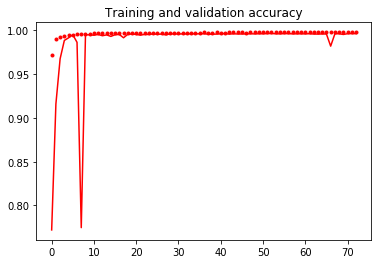

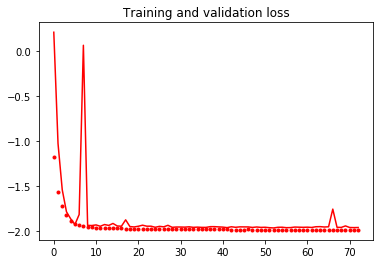

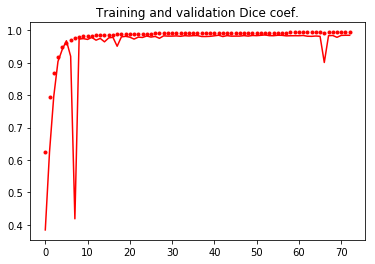

In [7]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard

weight_file_name = 'unet_no_mask_256_preprocessing_equalize_hist_color'

batch_size = 8
epochs = 100

print(orig_train_tensors.shape)
print(seg_train_tensors.shape)
print(orig_valid_tensors.shape)
print(seg_valid_tensors.shape)
             
callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=2, min_delta=1e-4),
             ModelCheckpoint(monitor='val_loss', filepath='./weights/' + str(weight_file_name) + '.hdf5', 
                             save_best_only=True, save_weights_only=True),
            TensorBoard(log_dir='./logs')]


history = model.fit(orig_train_tensors, seg_train_tensors, batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(orig_valid_tensors, seg_valid_tensors), callbacks=callbacks)

plot_training(history)
